In [2]:
import sys
sys.path.append('../')

from src.m4_generator import M4Generator
from src.m4_data_loader import M4DataLoader
from src.training_loss_functions import *
from src.m4_evaluation_loss_functions import *
from src.visualization import *
from src.evaluation import *
from src.m4_model import M4Model


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

# Load Data

In [3]:
EPOCHS = 1
BATCH_SIZE = 120
LOOKBACK = 48
HORIZON = 48
HIDDEN_LAYER_SIZE = 200
FEATURES_NUMBER = 1
CLIP_VALUE = 0.5
LEARNING_RATE = 0.01
DROPOUT_RATIO = 0.2

OUTPUT_SIZE = HORIZON*1
LOSS = smape

diffAugmentation = DiffAugmentation()
x_augmentations = []
y_augmentations = []

TRAIN_PATH = "../Dataset/splitted/Hourly-train.csv"
TEST_PATH = "../Dataset/splitted/Hourly-test.csv"
TRAIN_HOLDOUT_PATH = "../Dataset/splitted/Hourly-train-holdout.csv"
TEST_HOLDOUT_PATH = "../Dataset/splitted/Hourly-test-holdout.csv"

data_loader = M4DataLoader(TRAIN_PATH, TEST_PATH, TRAIN_HOLDOUT_PATH, TEST_HOLDOUT_PATH,
                           x_augmentations, y_augmentations, LOOKBACK, HORIZON)

train_x, train_y = data_loader.get_training_data()
test_x, test_y = data_loader.get_test_data()
holdout_x, holdout_y = data_loader.get_holdout_data()

training_data_generator = M4Generator(train_x, train_y, BATCH_SIZE, FEATURES_NUMBER)
test_data_generator = M4Generator(test_x, test_y, BATCH_SIZE, FEATURES_NUMBER)
holdout_data_generator = M4Generator(holdout_x, holdout_y, BATCH_SIZE, FEATURES_NUMBER)

# Train The Model

In [4]:
model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, batch_size=BATCH_SIZE, lookback=LOOKBACK, 
        output_size=OUTPUT_SIZE, learning_rate=LEARNING_RATE, loss = LOSS, dropout_ratio = DROPOUT_RATIO, 
        features_number = FEATURES_NUMBER)

model.train(training_data_generator, test_data_generator, epochs=EPOCHS)

Epoch 1/1
43/43 [==============================] - 42s 987ms/step - loss: 121.9149 - val_loss: 136.4803


# Save The Model

In [5]:
MODEL_BASE_DIR = '../models/point_predictions/1-LSTM'
model.save(MODEL_BASE_DIR)

Saved model files to disk under../models/point_predictions/1-LSTM/6


# Get Best And Worst Predictions

Loaded model from disk
Best Predection Error is     0.7623
Worst Predection Error is     1.7304


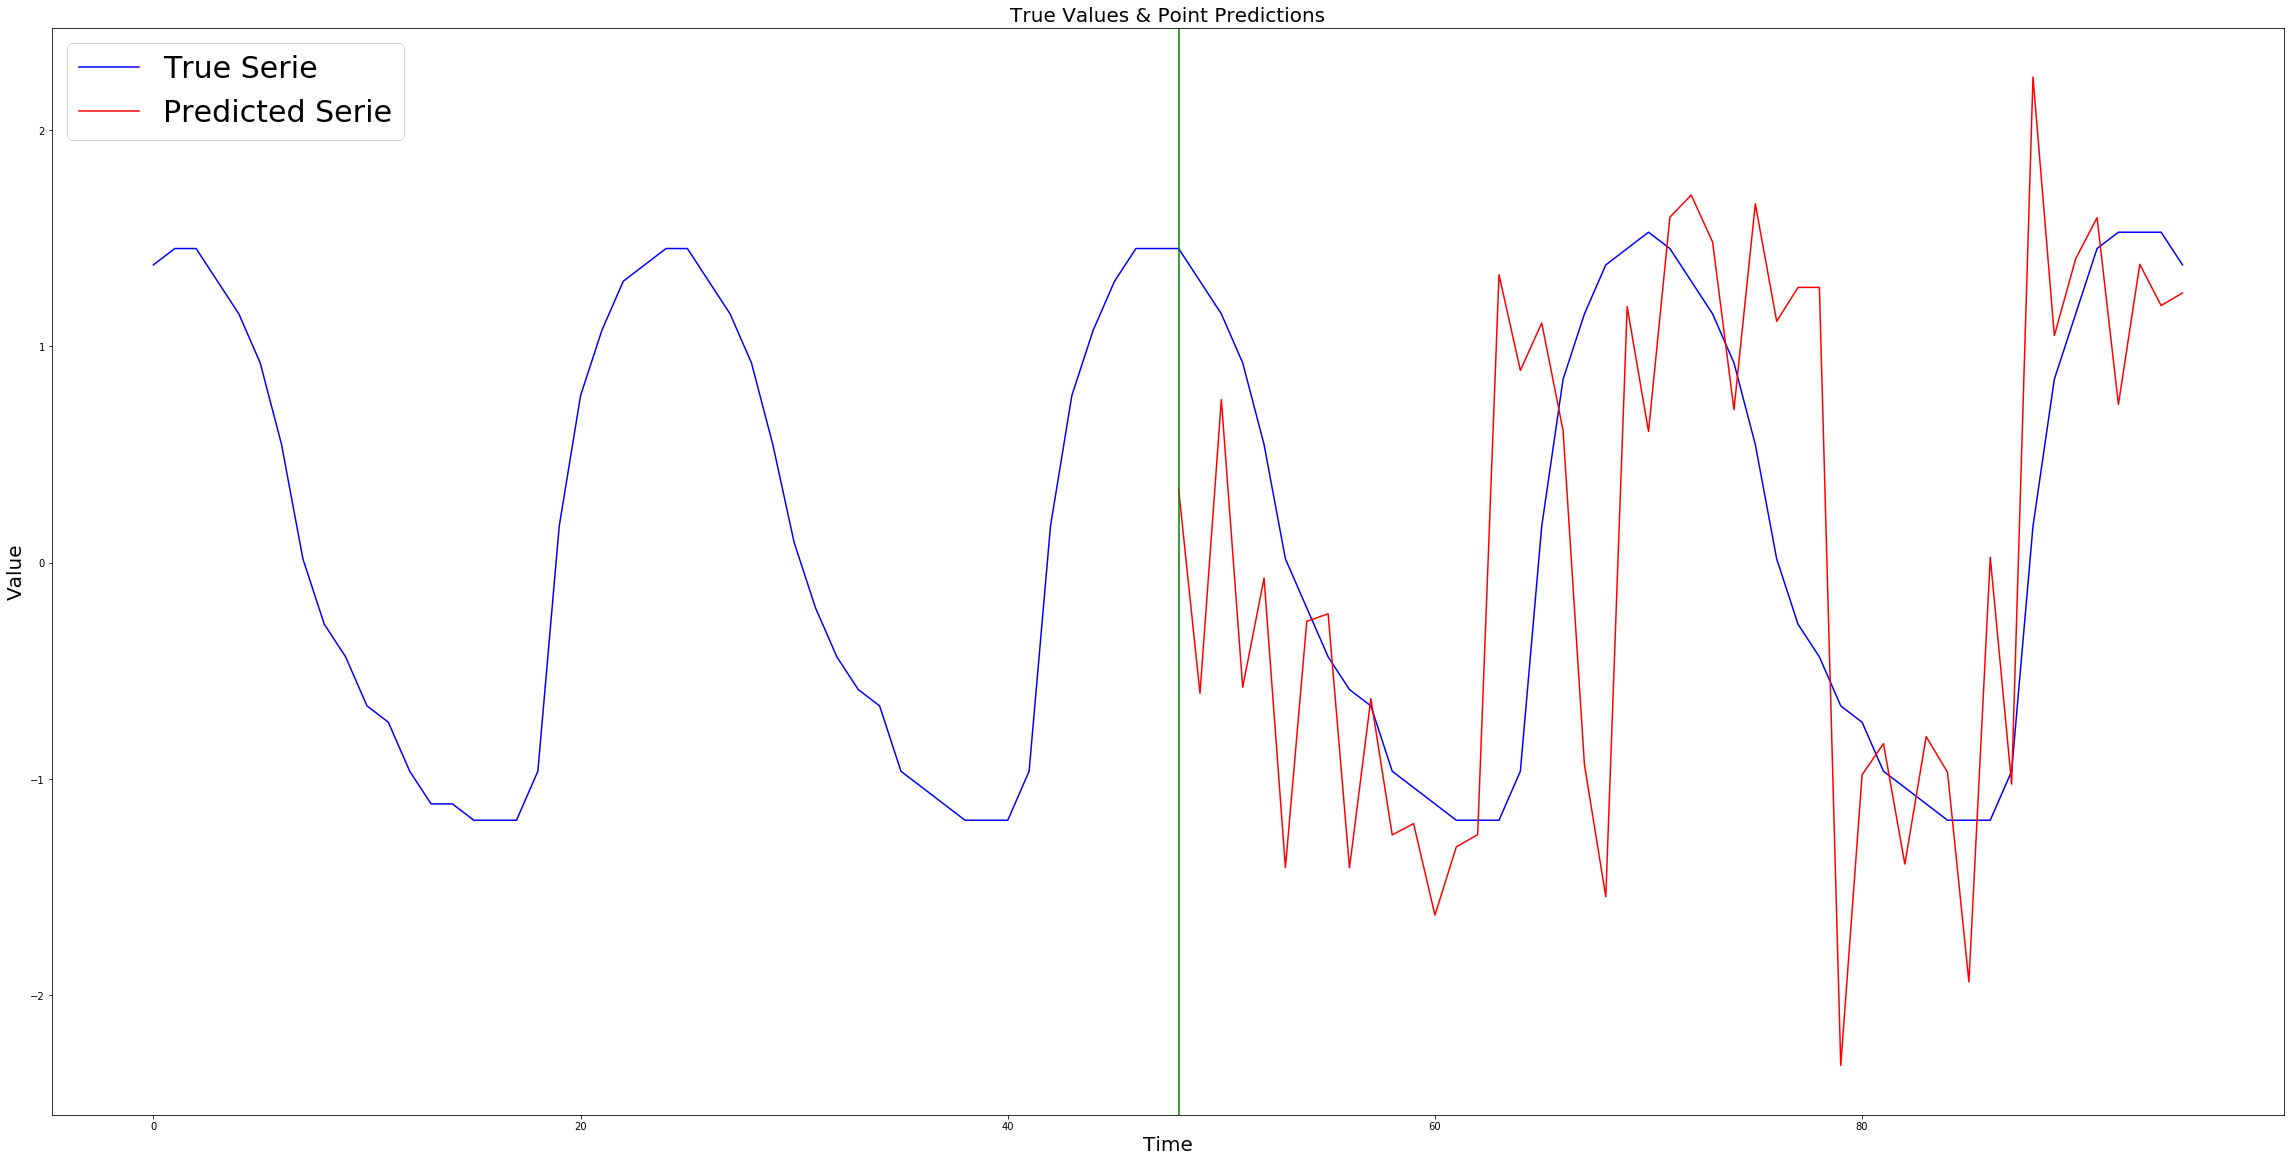

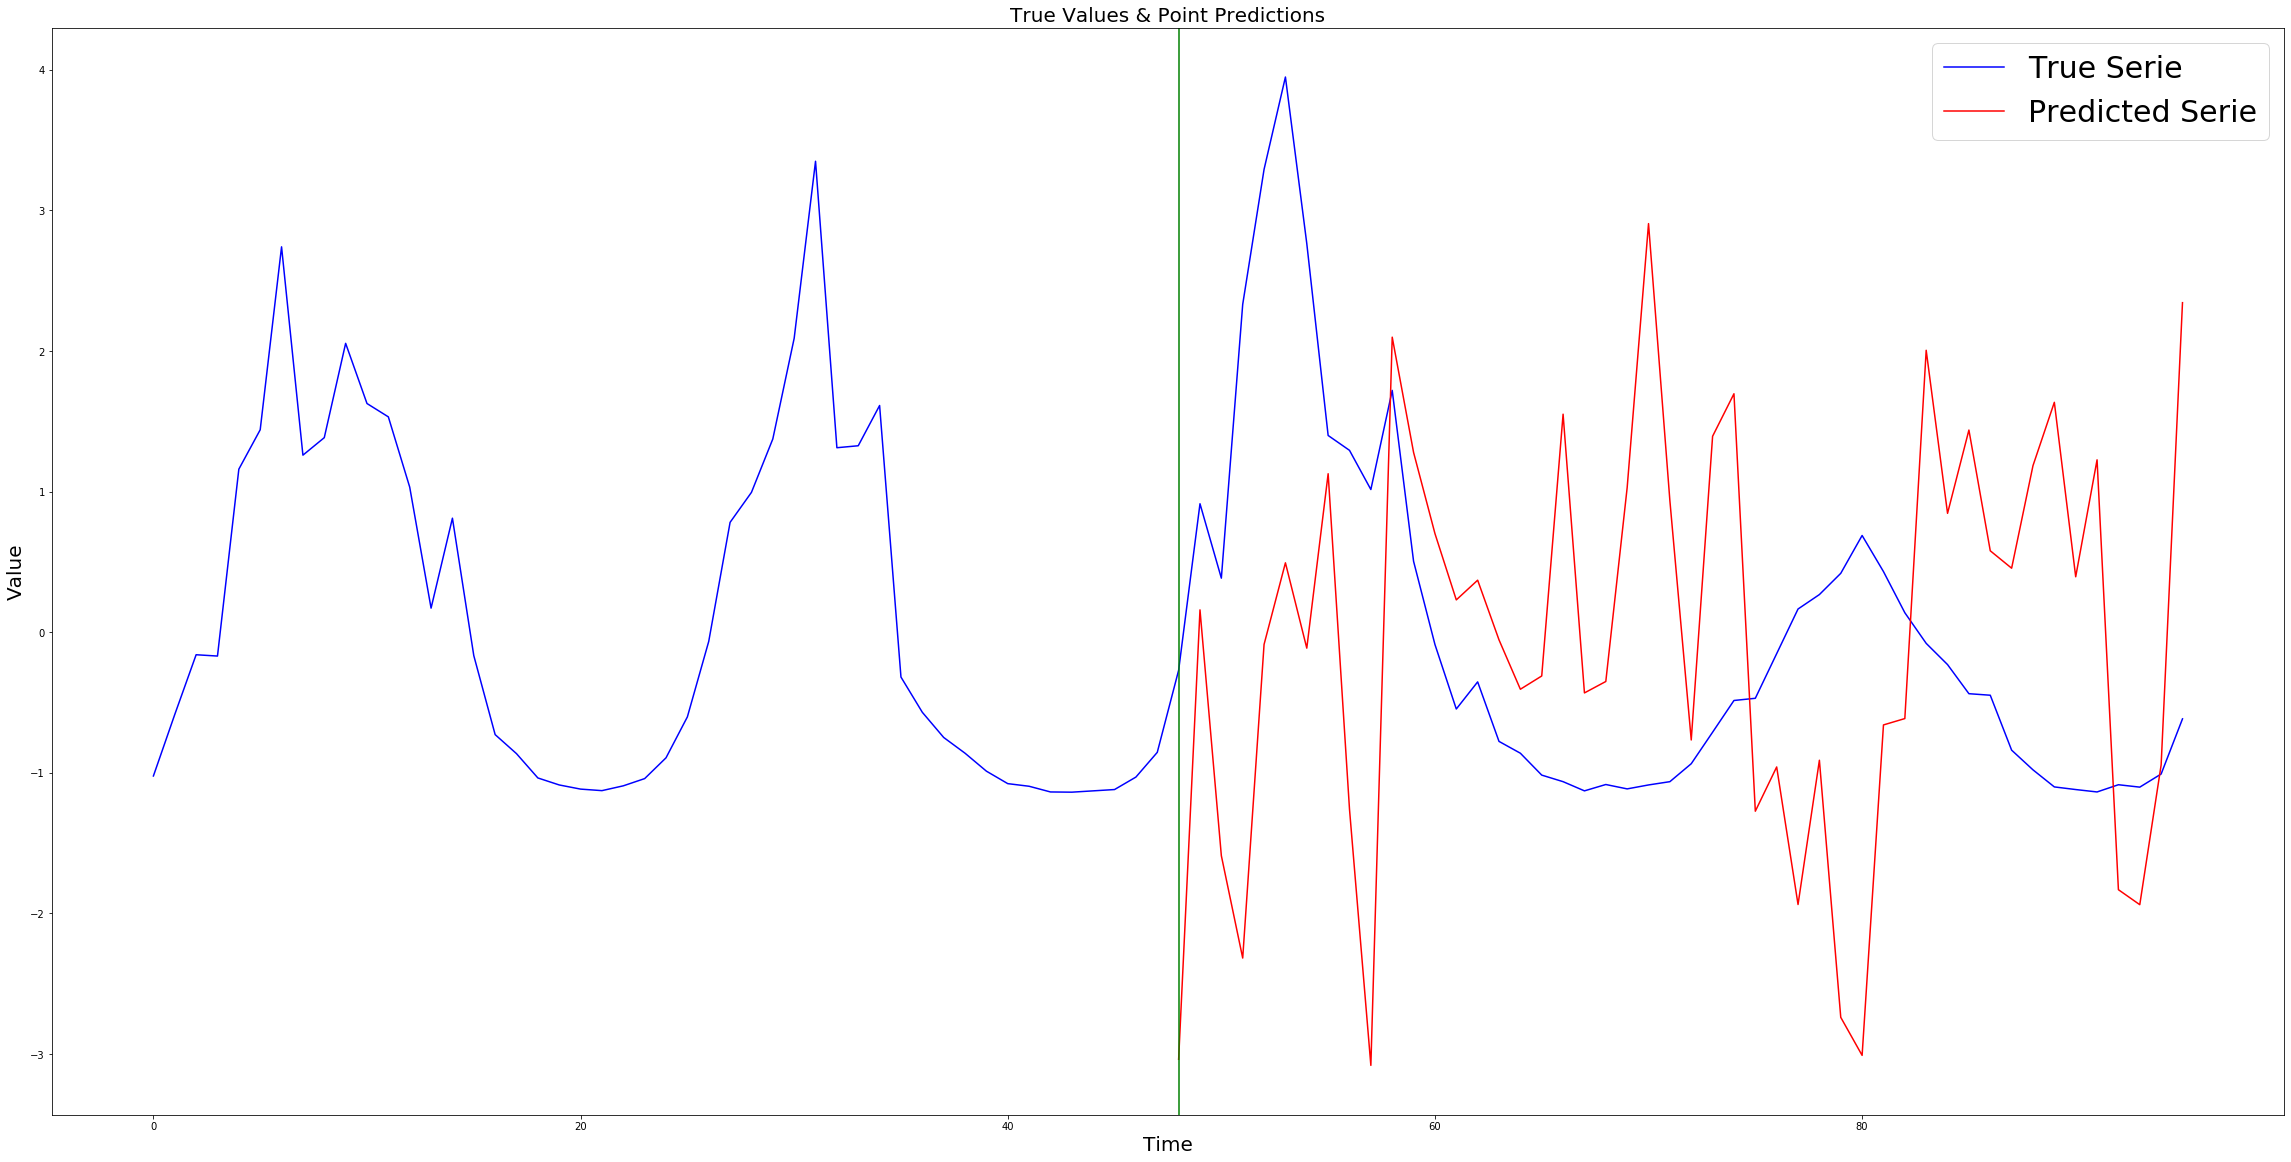

In [6]:
MODEL_BASE_DIR = '../models/point_predictions/1-LSTM/6'
model = M4Model()
hyperparameters = model.load(MODEL_BASE_DIR)
    
X, Y, Ypredictions, error =  sort_by_prediction_error(model,test_x, test_y, mae)

#unstandarized_Ypredictions = data_loader.unstandarize_predictions(Ypredictions)

if FEATURES_NUMBER == 1:
    X = X[:,:, np.newaxis]

print(f'Best Predection Error is {error[0]:10.4f}')
print(f'Worst Predection Error is {error[X.shape[0]-1]:10.4f}')

plot_serie_and_prediction(X[:,:,0], Y[:,:HORIZON], Ypredictions[:,:HORIZON], serie_indx=0)
plot_serie_and_prediction(X[:,:,0], Y[:,:HORIZON], Ypredictions[:,:HORIZON], serie_indx=X.shape[0]-1)

# PLot Specific Serie From Test Set

# Evaluate A Model Against An Error Function

In [7]:
MODEL_NUMBER = 2
MODEL_BASE_DIR = '../models/point_predictions/1-LSTM'
evaluation_results = load_and_evaluate_model(f'{MODEL_BASE_DIR}/{MODEL_NUMBER}', 
                                             TRAIN_PATH, TEST_PATH, 
                                             TRAIN_HOLDOUT_PATH, TEST_HOLDOUT_PATH,                                             x_augmentations, 
                                             y_augmentations, m4_mase)

print(f'Hyperparameters : {evaluation_results["hyperparameters"]}')
print(f'Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["test_error"]}')
print(f'Naive Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["naive_test_error"]}')
      
print(f'SNaive Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["snaive_test_error"]}')

print(f'holdout Error For Model ({MODEL_NUMBER}) : {evaluation_results["holdout_error"]}')
print(f'Naive holdout Error For Model ({MODEL_NUMBER}) : {evaluation_results["naive_holdout_error"]}')
print(f'SNaive holdout Error For Model ({MODEL_NUMBER}) : {evaluation_results["snaive_holdout_error"]}')


Loaded model from disk
Missing key'clipvalue'
Hyperparameters : {'epochs': 100, 'batch_size': 50, 'hidden_layer_size': 200, 'lookback': 48, 'loss': 'mae', 'dropout_ratio': 0.4, 'features_number': 1, 'output_size': 48}
Test Error For Model (2) : 2.032
Naive Test Error For Model (2) : 23.825
SNaive Test Error For Model (2) : 1.805
holdout Error For Model (2) : 1.264
Naive holdout Error For Model (2) : 3.399
SNaive holdout Error For Model (2) : 1.569
